Two‑input comparison across relative timing (NetStim; reuse previous soma+dend model)
  - Build a simple cell (soma with Hodgkin‑Huxley, passive dendrite).
  - Place two ExpSyn (AMPA‑like) on the dendrite at different locations.
  - Drive each synapse with a one‑shot NetStim; vary relative timing between the two inputs
    across 9 values from -20 ms to +20 ms.
  - For each timing condition record membrane potential at:
    - soma(0.5)
    - dend location 1 (synapse 1 site)
    - dend location 2 (synapse 2 site)
  - Plot the 9 responses side‑by‑side (one column per relative timing). Each column shows
    the three traces and vertical lines for stimulus times (presynaptic start) and arrival
    times (start + NetCon.delay).


Set up

In [14]:
from neuron import h
import numpy as np
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')

# -----------------
# Build simple cell
# -----------------
soma = h.Section(name='soma')
dend = h.Section(name='dend')

soma.L = soma.diam = 20.0    # µm
dend.L = 200.0
dend.diam = 1.0
dend.connect(soma(1))

for sec in (soma, dend):
	sec.Ra = 100
	sec.cm = 1.0

soma.insert('hh')
dend.insert('pas')
dend.g_pas = 1e-4
dend.e_pas = -65.0
dend.nseg = 11

# Synapse locations on the same dendrite
loc1 = 0.3
loc2 = 0.7

syn1 = h.ExpSyn(dend(loc1))
syn1.tau = 2.0
syn1.e = 0.0

syn2 = h.ExpSyn(dend(loc2))
syn2.tau = 2.0
syn2.e = 0.0

# NetCon weight and delay (same for both here)
weight = 0.001   # µS for ExpSyn (adjust to change EPSP size)
delay = 1.0      # ms

# Simulation timing
tstop = 180.0    # ms total
base_time = 80.0 # reference time for the first input (ms)

# Relative timing values (9 values from -20 to +20 ms)
rel_times = np.linspace(-10.0, 10.0, 9)

In [15]:
# Storage for results
results = []  # list of dicts with keys: t, v_soma, v_d1, v_d2, stim_times

# Run simulations for each relative timing
for dt in rel_times:
	# stimulus times for input 1 and input 2
	t1 = float(base_time)
	t2 = float(base_time + dt)

	# Create one-shot NetStims for exact event times
	ns1 = h.NetStim()
	ns1.start = t1
	ns1.number = 1
	ns1.interval = 1.0
	ns1.noise = 0.0

	ns2 = h.NetStim()
	ns2.start = t2
	ns2.number = 1
	ns2.interval = 1.0
	ns2.noise = 0.0

	# Connect to synapses
	nc1 = h.NetCon(ns1, syn1)
	nc1.delay = delay
	nc1.weight[0] = weight

	nc2 = h.NetCon(ns2, syn2)
	nc2.delay = delay
	nc2.weight[0] = weight

	# Recordings (new Vectors each run)
	tvec = h.Vector()
	v_soma = h.Vector()
	v_d1 = h.Vector()
	v_d2 = h.Vector()

	tvec.record(h._ref_t)
	v_soma.record(soma(0.5)._ref_v)
	v_d1.record(dend(loc1)._ref_v)
	v_d2.record(dend(loc2)._ref_v)

	# Run
	h.finitialize(-65.0)
	h.continuerun(tstop)

	# convert to numpy
	t = np.array(tvec)
	vs = np.array(v_soma)
	vd1 = np.array(v_d1)
	vd2 = np.array(v_d2)

	results.append({
		'dt': dt,
		't': t,
		'v_soma': vs,
		'v_d1': vd1,
		'v_d2': vd2,
		'stim_times': np.array([t1, t2]),
		'arrival_times': np.array([t1 + delay, t2 + delay]),
	})

	# Keep references to ns/nc until after simulation loop to avoid premature GC
	# (here local variables persist until overwritten by next loop iteration)


Plot.

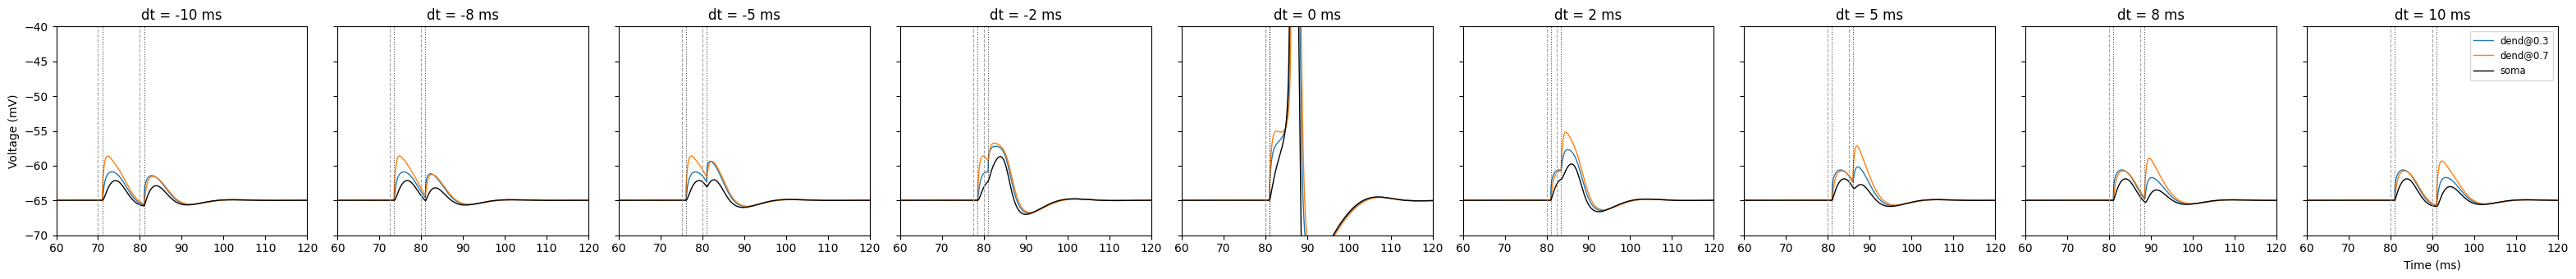

In [20]:
# -----------------
# Plot the results
# -----------------
n = len(results)
fig, axes = plt.subplots(1, n, sharey=True, figsize=(3.5 * n, 3.5))
if n == 1:
	axes = [axes]

for i, res in enumerate(results):
	ax = axes[i]
	t = res['t']
	ax.plot(t, res['v_d1'], color='C0', lw=1, label=f'dend@{loc1}')
	ax.plot(t, res['v_d2'], color='C1', lw=1, label=f'dend@{loc2}')
	ax.plot(t, res['v_soma'], color='k', lw=1, label='soma')

	# mark presynaptic times and arrival times
	for st in res['stim_times']:
		ax.axvline(st, color='0.6', linestyle='--', linewidth=0.8, alpha=0.9)
	for at in res['arrival_times']:
		ax.axvline(at, color='k', linestyle=':', linewidth=0.8, alpha=0.7)

	ax.set_xlim(base_time - 20, base_time + 40)  # focus window around inputs
	ax.set_title(f'dt = {res["dt"]:.0f} ms')
	if i == 0:
		ax.set_ylabel('Voltage (mV)')
	if i == n - 1:
		ax.legend(loc='upper right', fontsize='small')

plt.xlabel('Time (ms)')
plt.ylim(-70.0, -40.0)
plt.tight_layout()
plt.show()